In [2]:
import json

# Đường dẫn đến file JSON
file_path_train = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json'
file_path_valid = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json'
file_path_test = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json'


# Đọc file JSON
with open(file_path_train, 'r') as file:
    data_train = json.load(file)

with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)
    
with open(file_path_test, 'r') as file:
    data_test = json.load(file)
print(data_test)


{'info': {'year': '2023', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2023-08-19T04:37:54+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'Tumor', 'supercategory': 'none'}, {'id': 1, 'name': '0', 'supercategory': 'Tumor'}, {'id': 2, 'name': '1', 'supercategory': 'Tumor'}], 'images': [{'id': 0, 'license': 1, 'file_name': '1706_jpg.rf.004b87f63425ef145855aab826e33eee.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 1, 'license': 1, 'file_name': '1363_jpg.rf.01c4537b57f360820b9e00c7e0c99ae1.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 2, 'license': 1, 'file_name': '1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 

In [3]:
categories_train = data_train['categories']
images_train = data_train['images']
annotations_train = data_train['annotations']

categories_valid = data_valid['categories']
images_valid = data_valid['images']
annotations_valid = data_valid['annotations']

categories_test = data_test['categories']
images_test = data_test['images']
annotations_test = data_test['annotations']

In [4]:
def create_maskGt(segmentations, input_image):

  mask = np.zeros((input_image.height, input_image.width))
  for seg in segmentations:
    poly = np.array(seg).reshape((-1, 2))  # Chuyển đổi sang mảng numpy và định dạng lại
    img_poly = Polygon(poly)
    x, y = np.meshgrid(np.arange(input_image.width), np.arange(input_image.height))  # Tạo lưới điểm cho hình ảnh
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    path = img_poly.get_path()  # Lấy đường dẫn của đa giác
    grid = path.contains_points(points)
    grid = grid.reshape((input_image.height, input_image.width))  # Định dạng lại cho phù hợp với kích thước hình ảnh
    mask[grid] = 1  # Cập nhật mặt nạ


  return mask

In [5]:
import matplotlib.pyplot as plt

def visualize_masks(image, mask_gt, mask_pred_classic, mask_pred_finetune, figsize=(15, 15)):

    # Create a new figure with three subplots.
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot the ground truth mask on the second subplot.
    axes[0].imshow(image)
    axes[0].imshow(mask_gt, alpha =0.5)
    axes[0].set_title("Ground Truth Mask")

    # Plot the predicted mask on the third subplot.
    axes[1].imshow(image)
    axes[1].imshow(mask_pred_classic, alpha =0.5)
    axes[1].set_title("Predicted Mask Classic")
    
    # Plot the predicted mask on the third subplot.
    axes[2].imshow(image)
    axes[2].imshow(mask_pred_finetune, alpha =0.5)
    axes[2].set_title("Predicted Mask Finetune")

    # Show the figure.
    plt.show()

In [6]:
from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

file_path_train = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/'
file_path_val = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/'
file_path_test = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/'

imgs_train = []
for image in images_train:
    imgs_train.append(Image.open(file_path_train + image['file_name']))
    
msks_train = []
for i in range(len(imgs_train)):
    mask = create_maskGt(annotations_train[i]['segmentation'],imgs_train[i])
    msks_train.append(mask)
    
imgs_val = []
for image in images_valid:
    imgs_val.append(Image.open(file_path_val + image['file_name']))

msks_val = []
for i in range(len(imgs_val)):
    mask = create_maskGt(annotations_valid[i]['segmentation'],imgs_val[i])
    msks_val.append(mask)
    
imgs_test = []
for image in images_test:
    imgs_test.append(Image.open(file_path_test + image['file_name']))

msks_test = []
for i in range(len(imgs_test)):
    mask = create_maskGt(annotations_test[i]['segmentation'],imgs_test[i])
    msks_test.append(mask)
    
print(len(imgs_train))
print(len(msks_train))
print(len(imgs_val))
print(len(msks_val))
print(len(imgs_test))
print(len(msks_test))

1502
1502
429
429
215
215


In [7]:

from transformers import AutoProcessor, CLIPSegForImageSegmentation, CLIPSegConfig

processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model_class = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

2024-04-07 02:09:23.746217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 02:09:23.746325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 02:09:23.868797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
!pip install segmentation-models-pytorch

ValueError: filedescriptor out of range in select()

In [15]:
import torch.optim as optim
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

dice_loss = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Điều chỉnh learning rate theo thời gian

In [11]:
def evaluate_predictions(y_true, y_pred):
  """
  This function calculates the accuracy and IoU score for a set of predictions.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.

  Returns:
    A dictionary containing the accuracy and IoU score.
  """

  def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

  iou = iou_score(y_true, y_pred)

  return iou

In [16]:
import os

# Define the path for the log file
log_file_path = '/kaggle/working/training_log.txt'

# Make sure the file exists, if not, create it
if not os.path.exists(log_file_path):
    with open(log_file_path, 'w'): pass  # Just to create the file if it does not exist

# Define a function to append messages to the log file
def append_to_log(message):
    with open(log_file_path, 'a') as log_file:  # Open in append mode
        log_file.write(message + '\n')  # Append the message and a new line character

Epoch 1, Training loss: 0.7432280008627794, Validation loss: 0.614684879363, Test IoU: Finetune 0.2586736112100228 - Classic 0.001308086667502822


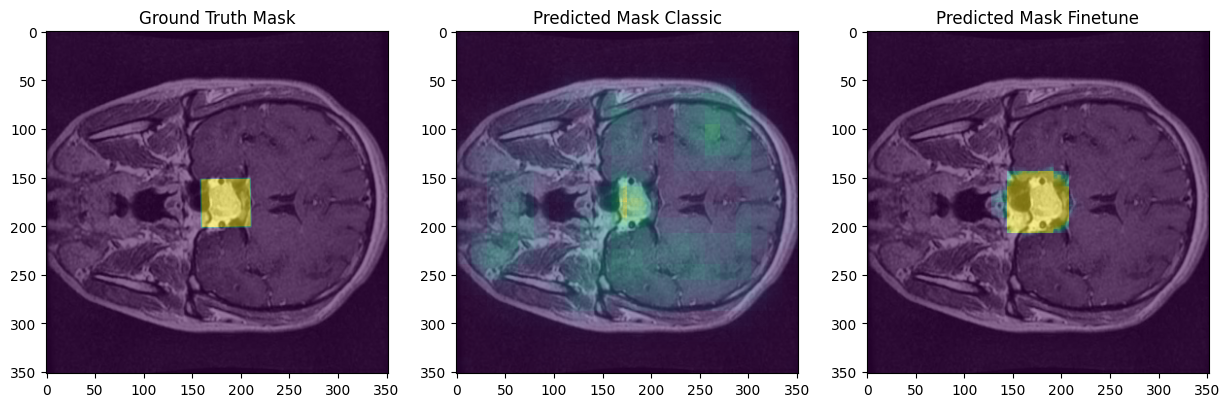

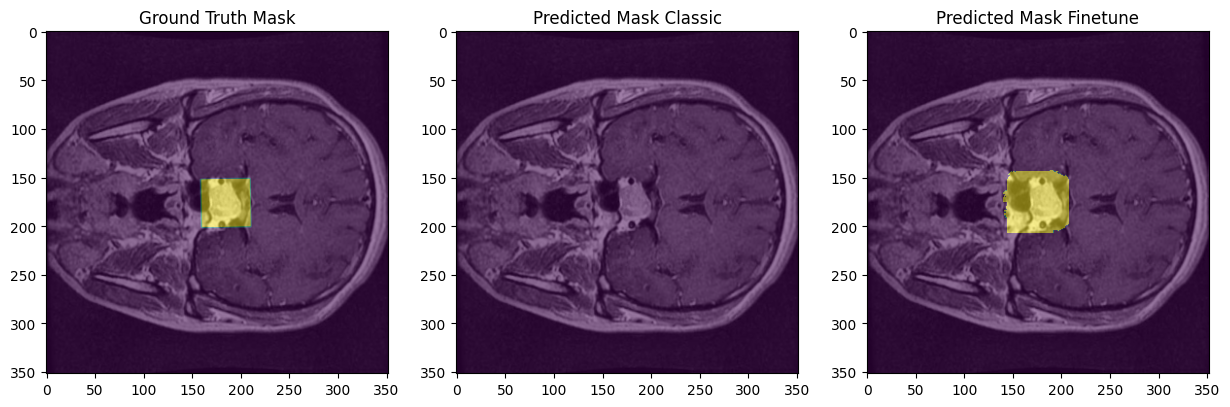

Epoch 2, Training loss: 0.6214291142639562, Validation loss: 0.5592604785254507, Test IoU: Finetune 0.3231271567126678 - Classic 0.0015917102676354716
Epoch 3, Training loss: 0.5832792971327841, Validation loss: 0.5154127828724735, Test IoU: Finetune 0.3549547338277625 - Classic 0.0010791693016282081
Epoch 4, Training loss: 0.5549570549423304, Validation loss: 0.48959697043145456, Test IoU: Finetune 0.3819006893134773 - Classic 0.003680689590375862
Epoch 5, Training loss: 0.5365202830888619, Validation loss: 0.4638046190177366, Test IoU: Finetune 0.40261804647427324 - Classic 0.0018736304089307784


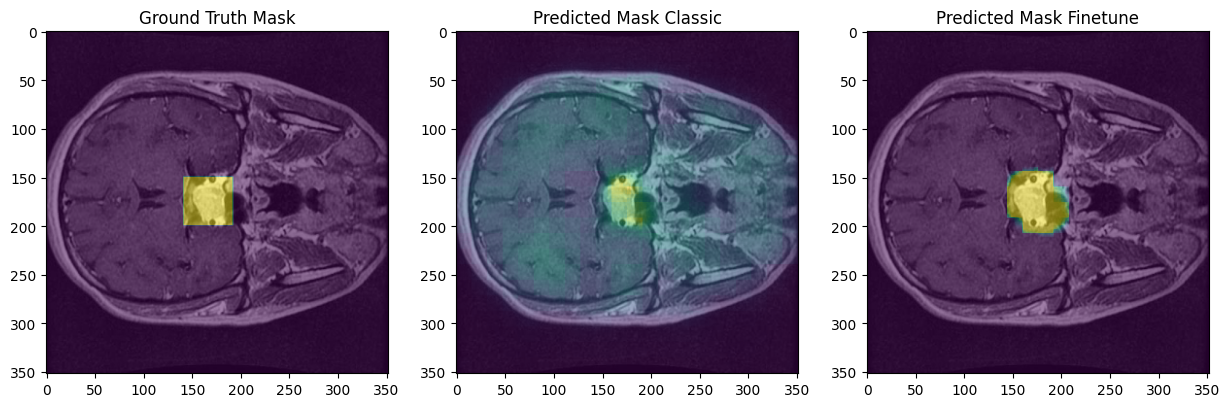

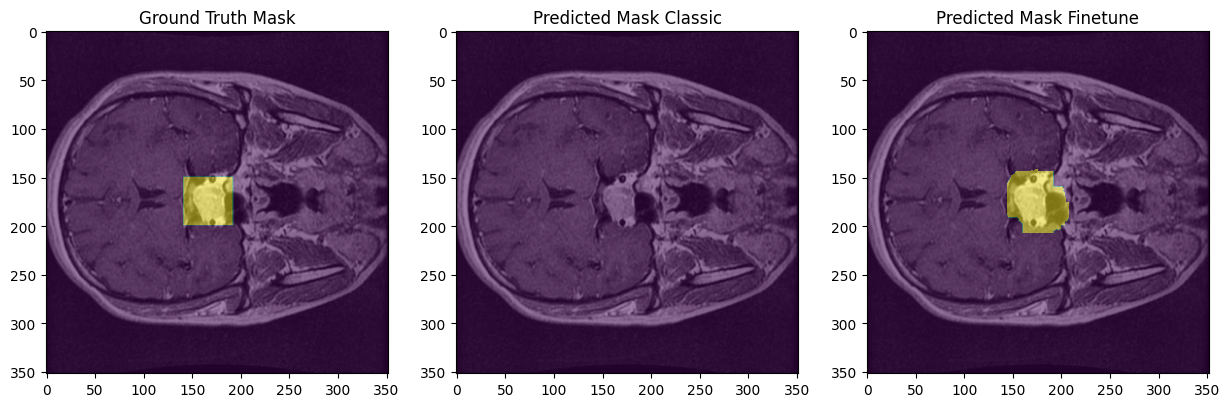

Epoch 6, Training loss: 0.5187676824758278, Validation loss: 0.451986853754048, Test IoU: Finetune 0.40418066873003894 - Classic 0.0007761190987145709
Epoch 7, Training loss: 0.5080206076330573, Validation loss: 0.4255052049121101, Test IoU: Finetune 0.4316208982156447 - Classic 0.0030035266199942984
Epoch 8, Training loss: 0.5047354117611277, Validation loss: 0.42420712551036915, Test IoU: Finetune 0.4410798569210312 - Classic 0.002863576203862629
Epoch 9, Training loss: 0.49239924784189215, Validation loss: 0.4059183179359614, Test IoU: Finetune 0.4549384328901279 - Classic 0.0007421380007003413
Epoch 10, Training loss: 0.48891772839740494, Validation loss: 0.4017508335602589, Test IoU: Finetune 0.45588206232822304 - Classic 0.0009555240295228697
Epoch 11, Training loss: 0.48087285961038106, Validation loss: 0.39475750673067317, Test IoU: Finetune 0.46416599024446126 - Classic 0.0015168799056086853
Epoch 12, Training loss: 0.47651414936296793, Validation loss: 0.3842231823014213, Tes

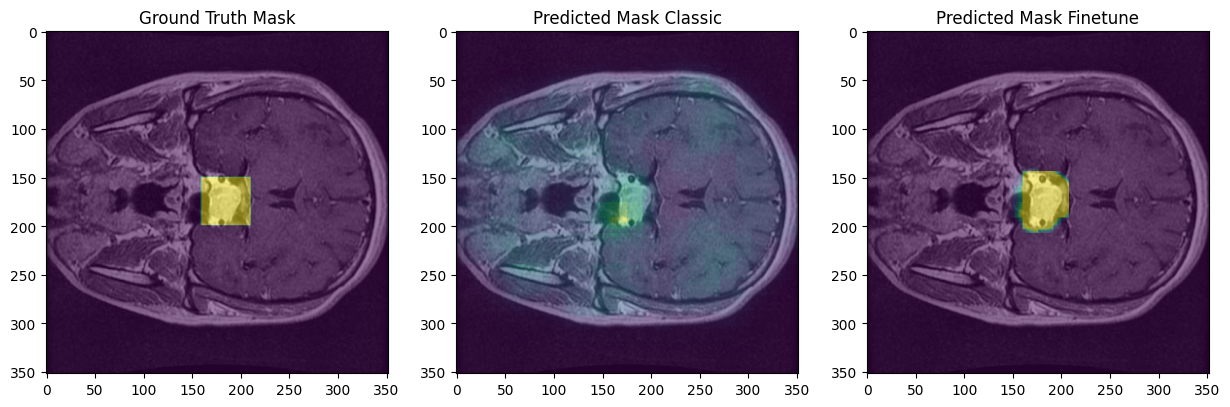

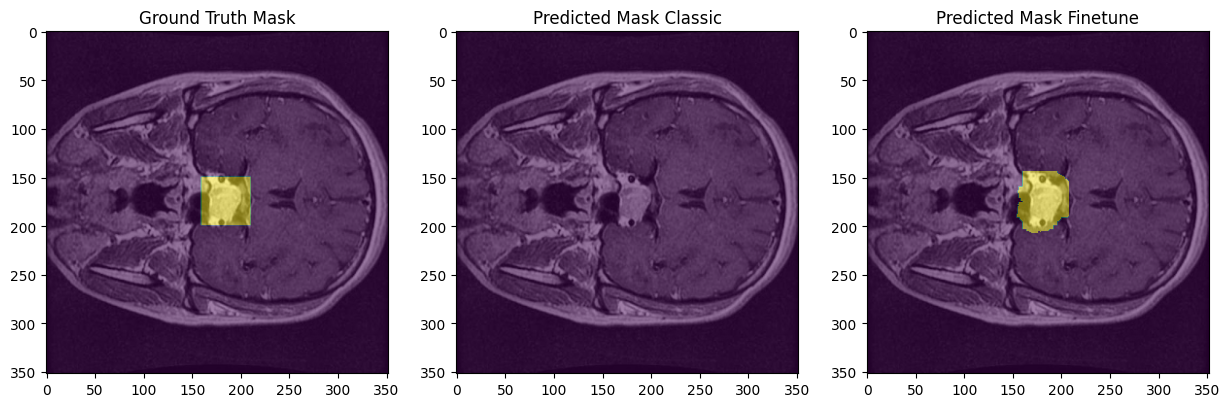

Epoch 21, Training loss: 0.4514127373298538, Validation loss: 0.3559194604555766, Test IoU: Finetune 0.5051908250957698 - Classic 0.0009922325737453056
Epoch 22, Training loss: 0.4423276214164678, Validation loss: 0.35718718608776173, Test IoU: Finetune 0.4978891673256933 - Classic 0.001924962148298932
Epoch 23, Training loss: 0.4448419606161816, Validation loss: 0.35154822142252, Test IoU: Finetune 0.5044970219272014 - Classic 0.0009479279165816398
Epoch 24, Training loss: 0.4392531824096065, Validation loss: 0.3502385200876178, Test IoU: Finetune 0.5076217403357675 - Classic 0.0
Epoch 25, Training loss: 0.43518490198449034, Validation loss: 0.34394862073840515, Test IoU: Finetune 0.5072302620131829 - Classic 0.0009381056704654663
Epoch 26, Training loss: 0.4385194527642546, Validation loss: 0.342443146905699, Test IoU: Finetune 0.5039915670200551 - Classic 0.0
Epoch 27, Training loss: 0.4343460558575098, Validation loss: 0.3466758091688712, Test IoU: Finetune 0.5050054696164105 - Cla

In [17]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_size = (352, 352)
model = model.to(device)
model_class = model_class.to(device)

num_epochs = 40
# Define an augmentation pipeline
transform = A.Compose([
    A.Resize(new_size[0], new_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10),
], additional_targets={'mask': 'image'})  # Định nghĩa rằng 'mask' cũng là một hình ảnh và cần được xử lý tương tự

epochs = []
train_losses = []
val_losses = []
iou_scoress_finetune = []
iou_scoress_classic = []
visualization_data = {
    'image': [],
    'mask_gt': [],
    'mask_pred_classic': [],
    'mask_pred_finetune': []
}
texts = ['tumor in brain']

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i in range(len(imgs_train)):
        augmented = transform(image=np.array(imgs_train[i]), mask=np.array(msks_train[i]))
        img_transformed = augmented['image']
        mask_transformed = augmented['mask']
        inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)
        outputs = model(**inputs)
        mask_tensor = torch.from_numpy(mask_transformed).to(device).unsqueeze(0)
        mask_resize = mask_tensor.detach().cpu().numpy()
        loss = dice_loss(outputs.logits, mask_tensor[0].to(device)) 
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(imgs_train)   
    
    # Giả sử dice_loss là hàm mất mát DiceLoss bạn đã khởi tạo
    model.eval()  # Chuyển mô hình sang mode đánh giá
    model_class.eval()
    val_loss = 0
    iou_scores_finetune = 0
    iou_scores_classic = 0
    
    with torch.no_grad():  # Không tính toán gradient trong block này
        for i in range(len(imgs_val)):
            augmented = transform(image=np.array(imgs_val[i]), mask=np.array(msks_val[i]))
            img_transformed = augmented['image']
            mask_transformed = augmented['mask']
            inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            mask_tensor = torch.from_numpy(mask_transformed).to(device).unsqueeze(0)
            loss = dice_loss(outputs.logits, mask_tensor[0].to(device))
            val_loss += loss.item()
            
        val_loss /= len(imgs_val)
        
        for i in range(len(imgs_test)):
            augmented = transform(image=np.array(imgs_test[i]), mask=np.array(msks_test[i]))
            img_transformed = augmented['image']
            mask_transformed = augmented['mask']
            
            inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)
            
            preds_finetune = model(**inputs)[0]
            preds_classic = model_class(**inputs)[0]

            preds_sigmods_finetune = torch.sigmoid(preds_finetune)
            preds_sigmods_classic = torch.sigmoid(preds_classic)

            preds_seg_finetune = preds_sigmods_finetune.cpu().detach().numpy()
            preds_seg_classic = preds_sigmods_classic.cpu().detach().numpy()

            mask_tensor = torch.from_numpy(mask_transformed).to(device).unsqueeze(0)
            mask_resize = mask_tensor.detach().cpu().numpy()
            
            if i == 2 and (epoch == 1 or epoch == 5 or epoch == 20 or epoch == 40):
                visualize_masks(img_transformed,mask_resize[0],preds_seg_classic,preds_seg_finetune)
                visualization_data['image'].append(img_transformed)
                visualization_data['mask_gt'].append(mask_resize[0])
                visualization_data['mask_pred_classic'].append(preds_seg_classic)
                visualization_data['mask_pred_finetune'].append(preds_seg_finetune)

            
            preds_seg_finetune = (preds_seg_finetune > 0.5).astype(np.uint8)
            preds_seg_classic = (preds_seg_classic > 0.5).astype(np.uint8)

            if i == 2 and (epoch == 1 or epoch == 5 or epoch == 20 or epoch == 40):
                visualize_masks(img_transformed,mask_resize[0],preds_seg_classic,preds_seg_finetune)
                visualization_data['image'].append(img_transformed)
                visualization_data['mask_gt'].append(mask_resize[0])
                visualization_data['mask_pred_classic'].append(preds_seg_classic)
                visualization_data['mask_pred_finetune'].append(preds_seg_finetune)

            iou_scores_finetune += evaluate_predictions(mask_resize,preds_seg_finetune)
            iou_scores_classic += evaluate_predictions(mask_resize,preds_seg_classic)
            
        iou_scores_finetune /= len(imgs_test)
        iou_scores_classic /= len(imgs_test)

    message = f'Epoch {epoch+1}, Training loss: {train_loss}, Validation loss: {val_loss}, Test IoU: Finetune {iou_scores_finetune} - Classic {iou_scores_classic}'
    append_to_log(message)
    print(message)
    
    scheduler.step()
    epochs.append(epoch+1)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    iou_scoress_finetune.append(iou_scores_finetune)
    iou_scoress_classic.append(iou_scores_classic)
    
    if epoch == 5 or epoch == 20 or epoch == 40 or epoch == 60 or epoch == 80 or epoch == 99:
        torch.save(model.state_dict(), '/kaggle/working/fine_tuned_CLIPSeg_{}.pth'.format(epoch))
    
torch.save(model.state_dict(), '/kaggle/working/fine_tuned_CLIPSeg.pth')
